In [33]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Install imbalanced-learn if not installed
try:
    from imblearn.over_sampling import RandomOverSampler
except ModuleNotFoundError:
    import sys
    !{sys.executable} -m pip install imbalanced-learn   
    from imblearn.over_sampling import RandomOverSampler

In [34]:
# Step 1: Load Data
categories = ['VeryMildDemented', 'MildDemented', 'ModerateDemented', 'NonDemented']
data_paths = {
    category: glob.glob(f"./augmented-alzheimer-mri-dataset-v2/data/val/{category}/*")
    for category in categories
}

data = []
labels = []

for i, category in enumerate(categories):
    for file_path in data_paths[category]:
        data.append(file_path)
        labels.append(i)

In [35]:

# Step 2: Handle Data Imbalance (Oversampling)
data = np.array(data)   
labels = np.array(labels)

# Oversample minority classes
ros = RandomOverSampler(random_state=42)
data_resampled, labels_resampled = ros.fit_resample(data.reshape(-1, 1), labels)
data_resampled = data_resampled.ravel()

In [36]:

# Step 3: Train-test Split
data_train, data_val, labels_train, labels_val = train_test_split(
    data_resampled, labels_resampled, test_size=0.2, stratify=labels_resampled, random_state=42
)

In [37]:

# Step 4: Data Preprocessing
def preprocess_image(file_path):
    import tensorflow as tf
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image

def create_dataset(file_paths, labels):
    import tensorflow as tf
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(lambda x, y: (preprocess_image(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset


In [38]:

train_dataset = create_dataset(data_train, labels_train)
val_dataset = create_dataset(data_val, labels_val)


In [39]:
# Step 5: Build the ResNet Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(categories), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [40]:
# Step 6: Training the Model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 736s 2s/step - accuracy: 0.4325 - loss: 1.2843 - val_accuracy: 0.6203 - val_loss: 0.7912
Epoch 2/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 727s 2s/step - accuracy: 0.5944 - loss: 0.8531 - val_accuracy: 0.6289 - val_loss: 0.7200
Epoch 3/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 722s 2s/step - accuracy: 0.6202 - loss: 0.7766 - val_accuracy: 0.6699 - val_loss: 0.6601
Epoch 4/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 659s 2s/step - accuracy: 0.6339 - loss: 0.7404 - val_accuracy: 0.7250 - val_loss: 0.6216
Epoch 5/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 670s 2s/step - accuracy: 0.6488 - loss: 0.7155 - val_accuracy: 0.6949 - val_loss: 0.6112
Epoch 6/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 746s 2s/step - accuracy: 0.6576 - loss: 0.6974 - val_accuracy: 0.7219 - val_loss: 0.5802
Epoch 7/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 670s 2s/step - accuracy: 0.6703 - loss: 0.6688 - val_accuracy: 0.7387 - val_loss: 0.5747
Epoch 8/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 667s 2s/step - accuracy: 0.6778 - loss: 0.6544 - val_accu

In [41]:
# Step 7: Evaluate the Model
eval_results = model.evaluate(val_dataset)
print(f"Validation Accuracy: {eval_results[1] * 100:.2f}%")

80/80 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.8406 - loss: 0.3957
Validation Accuracy: 82.89%


In [42]:

# Step 8: Performance Metrics
# Predictions on validation set
y_true = labels_val
y_pred = np.argmax(model.predict(val_dataset), axis=-1)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Validation Accuracy: {accuracy * 100:.2f}%')
print(f'Validation Precision: {precision * 100:.2f}%')
print(f'Validation Recall: {recall * 100:.2f}%')
print(f'Validation F1-Score: {f1 * 100:.2f}%')

80/80 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step
Validation Accuracy: 82.89%
Validation Precision: 82.69%
Validation Recall: 82.89%
Validation F1-Score: 82.70%


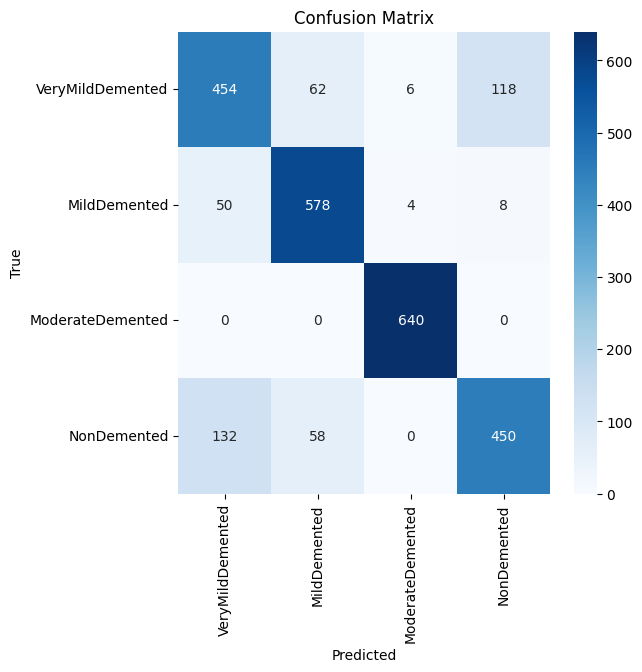

In [43]:

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

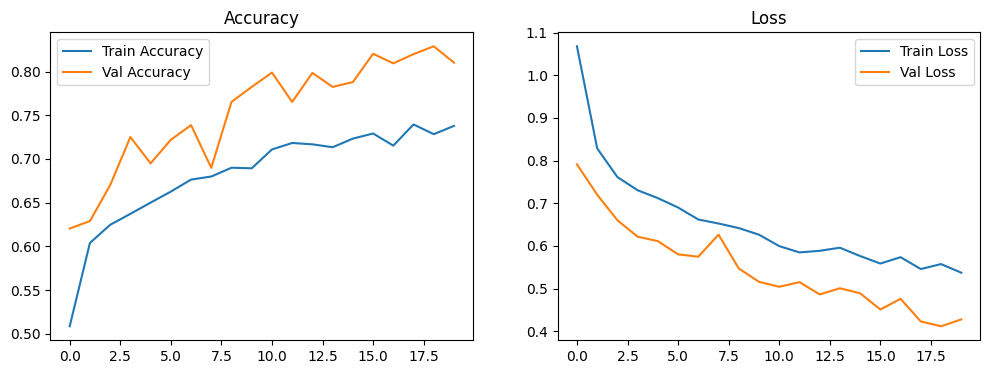

In [44]:

# Step 9: Plot Accuracy and Loss Curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [45]:
# Step 10: Save the Model
model.save('alzheimer_resnet_model.h5')

In [46]:
# Step 11: Fine-Tuning the Model
# Unfreeze Top Layers of ResNet50
for layer in base_model.layers[:140]:  # Keep lower layers frozen
    layer.trainable = False
for layer in base_model.layers[140:]:  # Unfreeze top layers
    layer.trainable = True


In [47]:
# Recompile the Model
from tensorflow.keras.optimizers import Adam


fine_tune_lr = 1e-5
model.compile(optimizer=Adam(learning_rate=fine_tune_lr), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [48]:

# Fine-tune the Model
history_fine_tune = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,  # Additional epochs for fine-tuning
    callbacks=[early_stopping]
)


Epoch 1/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 838s 3s/step - accuracy: 0.6452 - loss: 2.0147 - val_accuracy: 0.8094 - val_loss: 0.4224
Epoch 2/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 851s 3s/step - accuracy: 0.7737 - loss: 0.4752 - val_accuracy: 0.8672 - val_loss: 0.3162
Epoch 3/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 872s 3s/step - accuracy: 0.8127 - loss: 0.3891 - val_accuracy: 0.9004 - val_loss: 0.2553
Epoch 4/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 836s 3s/step - accuracy: 0.8553 - loss: 0.3027 - val_accuracy: 0.9133 - val_loss: 0.2183
Epoch 5/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 855s 3s/step - accuracy: 0.8821 - loss: 0.2619 - val_accuracy: 0.9410 - val_loss: 0.1693
Epoch 6/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 851s 3s/step - accuracy: 0.9034 - loss: 0.2229 - val_accuracy: 0.9426 - val_loss: 0.1505
Epoch 7/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 854s 3s/step - accuracy: 0.9202 - loss: 0.1845 - val_accuracy: 0.9512 - val_loss: 0.1289
Epoch 8/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 851s 3s/step - accuracy: 0.9326 - loss: 0.1677 - val_accu

In [49]:
# Evaluate Fine-tuned Model
eval_results_fine_tune = model.evaluate(val_dataset)
print(f"Fine-tuned Validation Accuracy: {eval_results_fine_tune[1] * 100:.2f}%")


80/80 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.9653 - loss: 0.0798
Fine-tuned Validation Accuracy: 96.41%


In [50]:

# Performance Metrics after Fine-tuning
y_true_fine_tune = labels_val
y_pred_fine_tune = np.argmax(model.predict(val_dataset), axis=-1)

accuracy_fine_tune = accuracy_score(y_true_fine_tune, y_pred_fine_tune)
precision_fine_tune = precision_score(y_true_fine_tune, y_pred_fine_tune, average='weighted')
recall_fine_tune = recall_score(y_true_fine_tune, y_pred_fine_tune, average='weighted')
f1_fine_tune = f1_score(y_true_fine_tune, y_pred_fine_tune, average='weighted')

print(f'Fine-Tuned Validation Accuracy: {accuracy_fine_tune * 100:.2f}%')
print(f'Fine-Tuned Validation Precision: {precision_fine_tune * 100:.2f}%')
print(f'Fine-Tuned Validation Recall: {recall_fine_tune * 100:.2f}%')
print(f'Fine-Tuned Validation F1-Score: {f1_fine_tune * 100:.2f}%')


80/80 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step
Fine-Tuned Validation Accuracy: 96.41%
Fine-Tuned Validation Precision: 96.47%
Fine-Tuned Validation Recall: 96.41%
Fine-Tuned Validation F1-Score: 96.40%


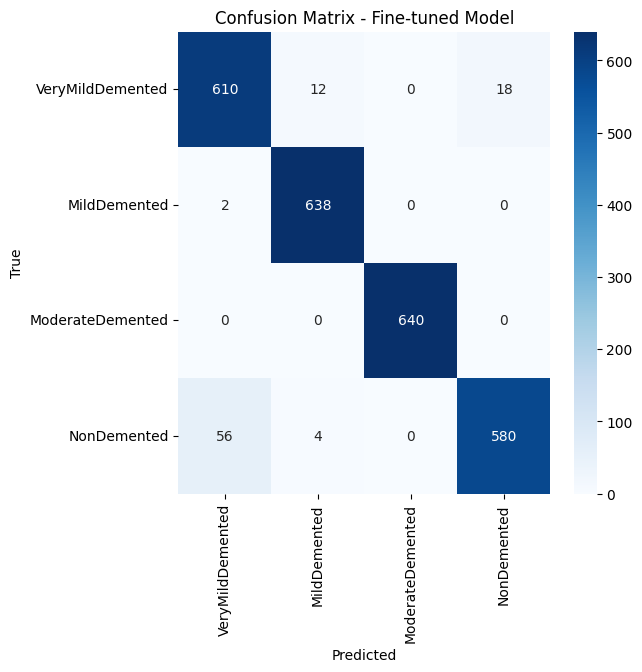

In [51]:

# Confusion Matrix after Fine-tuning
cm_fine_tune = confusion_matrix(y_true_fine_tune, y_pred_fine_tune)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_fine_tune, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Fine-tuned Model')
plt.show()

In [52]:

# Save the fine-tuned model
model.save('fine_tuned_resnet50.h5')

# Save the trained model in .h5 format
model.save('fine_tuned_resnet50-1.h5', save_format='h5')

model.save('fine_tuned_resnet50.keras')